## SIR propagation

In [10]:
%reset -f

In [11]:
%pip install ..

Processing /home/sean/Workspaces/contact-networks
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for contact-networks, since package 'wheel' is not installed.
  Attempting uninstall: contact-networks
    Found existing installation: contact-networks 0.1.0
    Uninstalling contact-networks-0.1.0:
      Successfully uninstalled contact-networks-0.1.0
  Running setup.py install for contact-networks ... done
Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from contact_networks import graph_metrics, sir_propagation
from contact_networks import utils

In [13]:
colors = [
    '#E69F00',  # Soft Orange
    '#56B4E9',  # Sky Blue
    '#009E73',  # Teal Green
    '#CC79A7',  # Muted Purple
    '#F0E442',  # Golden Yellow
    '#0072B2',  # Slate Blue
    '#D55E00',  # Coral Red
]

# Set the color cycle permanently in rcParams
mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

In [14]:
data = utils.load_data()

In [15]:
beta = 4e-4
mu = lambda delta, k: delta * beta / k
del_t = (5e-3) / beta
stop_time = np.inf
ks = [5,4,3,2,1]
n_samples = 100

In [16]:
def get_proportions_recovered(adj_matrix, delta, k):
    n_nodes = adj_matrix.shape[0]
    proportions_recovered = np.zeros(n_samples)
    for idx in range(n_samples):
        _, _, recovered = sir_propagation.sir_propagation(
            adj_matrix, 
            infection_rate=beta, 
            recovery_rate=mu(delta, k),
            step_size=del_t,
            stop_time=stop_time,
            initial_infected=np.random.choice(adj_matrix.shape[0])
        )
        proportion_recovered = recovered.size / n_nodes
        proportions_recovered[idx] = proportion_recovered
    dbar = graph_metrics.average_degree(adj_matrix)
    rho0 = k * dbar / delta
    return proportions_recovered, rho0

In [17]:
def plot_proportion_counts(ax, proportions, rho0):   
    # proportions, counts = np.unique(proportions, return_counts=True)
    hist, bins = np.histogram(proportions, bins=40)
    centers = (bins[:-1] + bins[1:]) / 2
    ax.plot(
        centers,
        hist / hist.sum(), 
        linewidth=1,
        label=rf"$\rho_0=${rho0:.2f}"
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_yscale('function', functions=(lambda x: np.sqrt(x), lambda x: x**2))
    ax.set_xlabel("Proportion of nodes recovered")
    ax.set_ylabel("Density")


def plot_ax_proportion_counts(ax, adj_matrix, delta, ks):
    for k in ks:
        proportions, rho0 = get_proportions_recovered(
            adj_matrix=adj_matrix,
            delta=delta,
            k=k
        )
        plot_proportion_counts(
            ax=ax,
            proportions=proportions,
            rho0=rho0
        )
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


def plot_subfig_proportion_counts(axes, X, ks):
    axes = axes.ravel()
    plot_ax_proportion_counts(
        ax=axes[0],  
        adj_matrix=X['face-to-face'], 
        delta=10, 
        ks=ks
    )
    axes[0].set_title('Face-to-Face Network')
    plot_ax_proportion_counts(
        ax=axes[1],
        adj_matrix=X['co-present'],
        delta=50,
        ks=ks
    )
    axes[1].set_title('Co-present Network')


def plot_supfig_proportion_counts(data, ks):
    ks = np.array(ks)

    fig = plt.figure(layout='constrained', figsize=(15,20))
    subfigs = fig.subfigures(6, 1, hspace=0)

    for subfig, (key, X) in zip(subfigs.ravel(), data.items()):
        axes = subfig.subplots(1, 2, sharey=False)
        plot_subfig_proportion_counts(axes, X, ks)
        subfig.suptitle(f"{key} Dataset", fontsize=10, fontweight='bold')

    fig.suptitle(r'Density of proportion of nodes recovered for several $\rho_0$ values')

    return fig

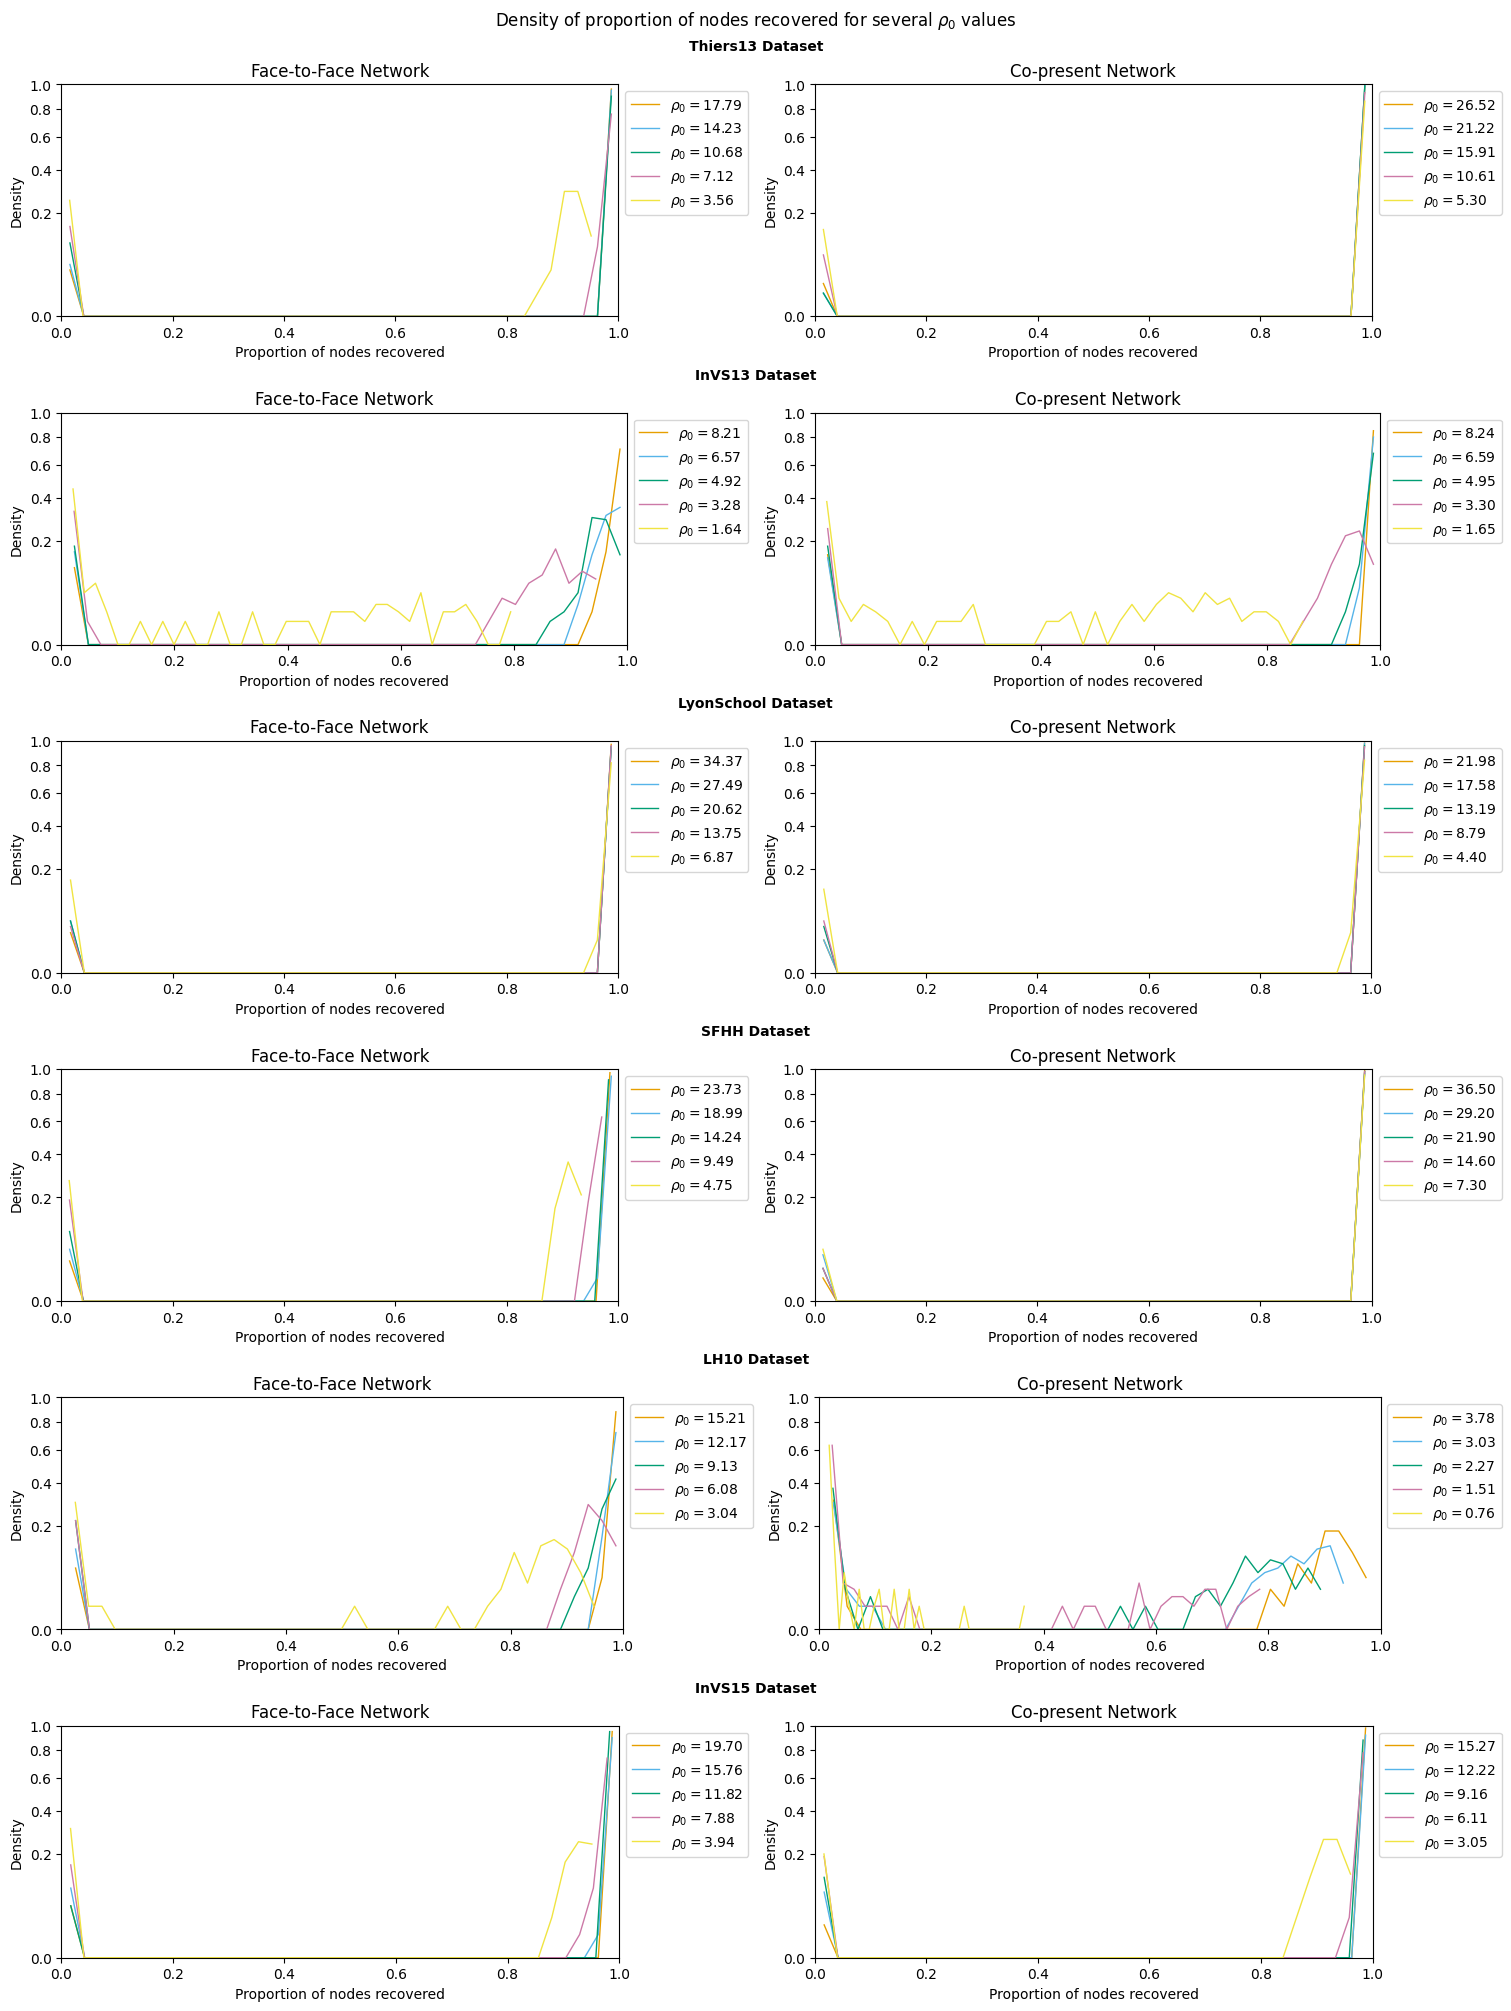

In [18]:
fig = plot_supfig_proportion_counts(data, ks)
plt.show()

In [19]:
def get_proportions_major(adj_matrix, delta, ks):
    proportions_major = np.zeros(ks.size)
    rho0s = np.zeros(ks.size)
    for idx, k in enumerate(ks):
        proportions_recovered, rho0 = get_proportions_recovered(
            adj_matrix=adj_matrix,
            delta=delta,
            k=k
        )
        rho0s[idx] = rho0
        proportion_major = proportions_recovered[proportions_recovered > 0.2].size / proportions_recovered.size
        proportions_major[idx] = proportion_major
    return proportions_major, rho0s

In [20]:
def plot_proportions_major(ax, label, adj_matrix, delta, ks):
    proportions_major, rho0s = get_proportions_major(
        adj_matrix=adj_matrix, 
        delta=delta, 
        ks=ks
    )
    ax.plot(
        rho0s,
        proportions_major,
        linewidth=1,
        marker='o',
        label=label
    )
    ax.set_ylim([0,1])
    ax.set_ylabel("Proportion of major epidemics")
    ax.set_xlabel(r"$\rho_0$")


def plot_fig_proportions_major(data, ks):
    ks = np.array(ks)

    fig = plt.figure(layout='constrained', figsize=(16, 8))
    axes = fig.subplots(1, 2)
    axes = axes.ravel()

    for key, X in data.items():
        plot_proportions_major(
            axes[0], 
            label=key, 
            adj_matrix=X['face-to-face'],
            delta=10,
            ks=ks
        )
        plot_proportions_major(
            axes[1],
            label=key,
            adj_matrix=X['co-present'],
            delta=50,
            ks=ks
        )
    axes[0].set_title('Face-to-Face Network')
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axes[1].set_title('Co-present Network')
    axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

    fig.suptitle(r'Proportion of major epidemics out of total for several $\rho_0$ values')

    return fig

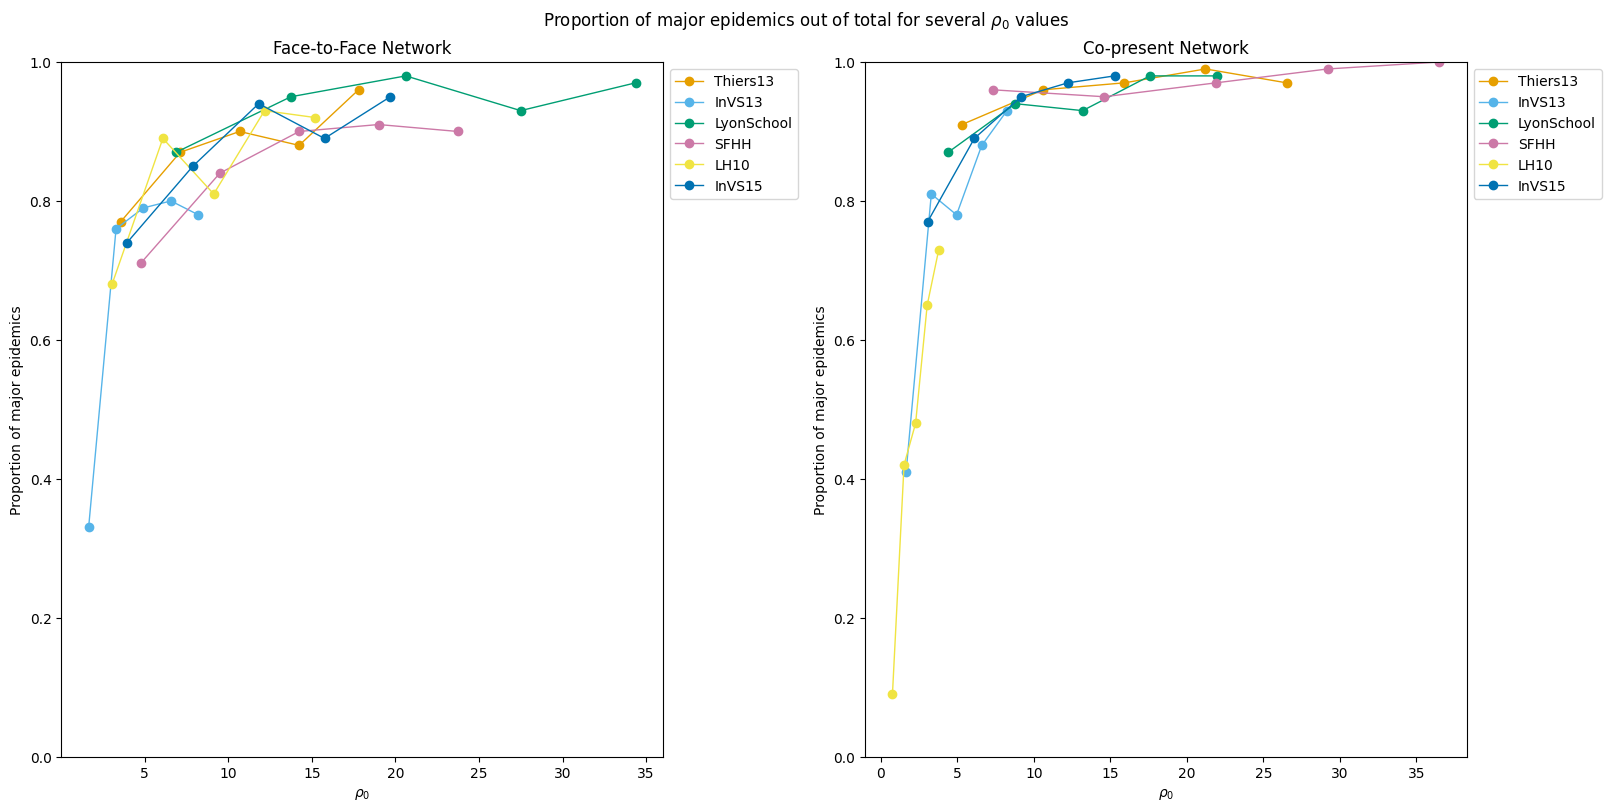

In [21]:
fig = plot_fig_proportions_major(data, ks)
plt.show()

In [22]:
def get_average_proportion_recovered(adj_matrix, delta, k):
    n_nodes = adj_matrix.shape[0]
    proportions_recovered = np.zeros(n_samples)
    for idx in range(n_samples):
        _, _, recovered = sir_propagation.sir_propagation(
            adj_matrix, 
            infection_rate=beta, 
            recovery_rate=mu(delta, k),
            step_size=del_t,
            stop_time=stop_time,
            initial_infected=np.random.choice(adj_matrix.shape[0])
        )
        proportion_recovered = recovered.size / n_nodes
        proportions_recovered[idx] = proportion_recovered
    dbar = graph_metrics.average_degree(adj_matrix)
    rho0 = k * dbar / delta
    return np.mean(proportions_recovered), rho0


def get_average_proportions_recovered(adj_matrix, delta, ks):
    average_proportions_recovered = np.zeros(ks.size)
    rho0s = np.zeros(ks.size)
    for idx, k in enumerate(ks):
        average_proportion_recovered, rho0 = get_average_proportion_recovered(
            adj_matrix=adj_matrix,
            delta=delta,
            k=k
        )
        rho0s[idx] = rho0
        average_proportions_recovered[idx] = average_proportion_recovered
    return average_proportions_recovered, rho0s

In [23]:
def plot_average_proportions_recovered(ax, label, adj_matrix, delta, ks):
    average_proportions_recovered, rho0s = get_average_proportions_recovered(
        adj_matrix=adj_matrix, 
        delta=delta, 
        ks=ks
    )
    ax.plot(
        rho0s,
        average_proportions_recovered,
        linewidth=1,
        marker='o',
        label=label
    )
    ax.set_ylim([0,1])
    ax.set_ylabel("Average proportion of nodes recovered")
    ax.set_xlabel(r"$\rho_0$")


def plot_fig_average_proportions_recovered(data, ks):
    ks = np.array(ks)

    fig = plt.figure(layout='constrained', figsize=(16, 8))
    axes = fig.subplots(1, 2)
    axes = axes.ravel()

    for key, X in data.items():
        plot_average_proportions_recovered(
            axes[0], 
            label=key, 
            adj_matrix=X['face-to-face'],
            delta=10,
            ks=ks
        )
        plot_average_proportions_recovered(
            axes[1],
            label=key,
            adj_matrix=X['co-present'],
            delta=50,
            ks=ks
        )
    axes[0].set_title('Face-to-Face Network')
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axes[1].set_title('Co-present Network')
    axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

    fig.suptitle(r'Average proportion of nodes recovered from major epidemics by $\rho_0$')

    return fig

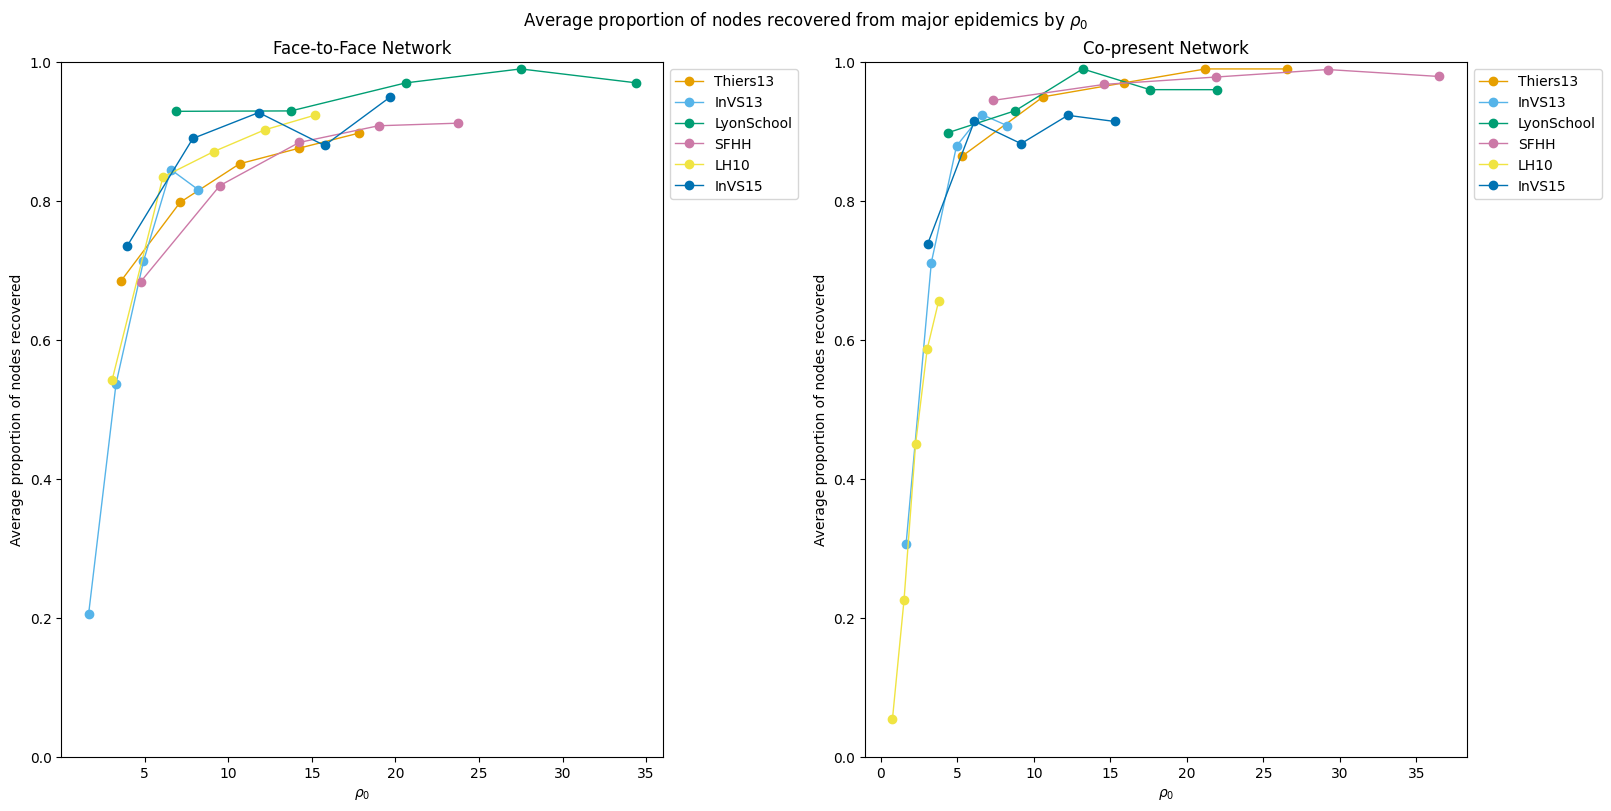

In [24]:
fig = plot_fig_average_proportions_recovered(data, ks)
plt.show()